<a href="https://colab.research.google.com/github/atheendre130505/gans_monet/blob/main/monet_cyclicGan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import zipfile, os

for fname in ['photo.zip', 'monet.zip']:
    with zipfile.ZipFile(fname, 'r') as zip_ref:
        zip_ref.extractall('/content/dataset')
print(os.listdir('/content/dataset'))

['monet_jpg', 'photo_jpg']


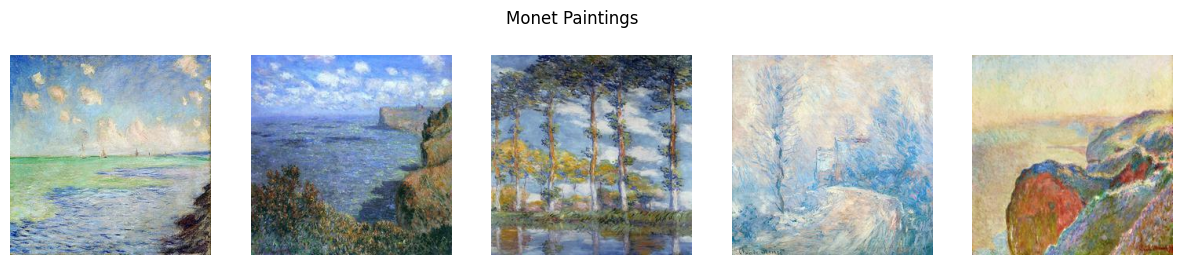

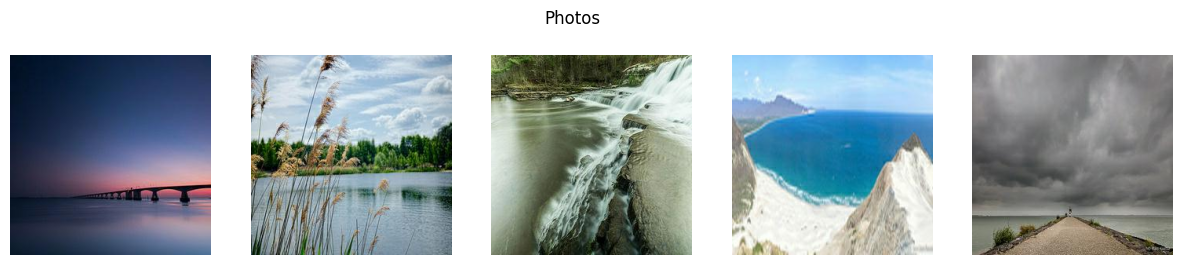

In [ ]:
import matplotlib.pyplot as plt
import cv2
import random
from glob import glob

monet_paths = glob('/content/dataset/monet_jpg/*')
photo_paths = glob('/content/dataset/photo_jpg/*')

def show_samples(img_paths, title, n=5):
    plt.figure(figsize=(15,3))
    for i, path in enumerate(random.sample(img_paths, n)):
        img = cv2.imread(path)[:,:,::-1]
        plt.subplot(1,n,i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

show_samples(monet_paths, "Monet Paintings")
show_samples(photo_paths, "Photos")


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.utils import save_image
import numpy as np
import cv2
from glob import glob
import random
from PIL import Image
import os

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [ ]:
class ResnetBlock(nn.Module):
    def __init__(self, dim):
        super(ResnetBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, 3),
            nn.InstanceNorm2d(dim),
            nn.ReLU(True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, 3),
            nn.InstanceNorm2d(dim)
        )

    def forward(self, x):
        return x + self.conv_block(x)

class Generator(nn.Module):
    def __init__(self, input_nc=3, output_nc=3, n_residual_blocks=6):
        super(Generator, self).__init__()

        # Initial convolution block
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(input_nc, 32, 7),
            nn.InstanceNorm2d(32),
            nn.ReLU(True)
        ]

        # Downsampling
        in_features = 32
        out_features = in_features * 2
        for _ in range(2):
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(True)
            ]
            in_features = out_features
            out_features = in_features * 2

        # Residual blocks
        for _ in range(n_residual_blocks):
            model += [ResnetBlock(in_features)]

        # Upsampling
        out_features = in_features // 2
        for _ in range(2):
            model += [
                nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(True)
            ]
            in_features = out_features
            out_features = in_features // 2

        # Output layer
        model += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(32, output_nc, 7),
            nn.Tanh()
        ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)


In [ ]:
class Discriminator(nn.Module):
    def __init__(self, input_nc=3):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, normalize=True):
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(input_nc, 32, normalize=False),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            nn.Conv2d(256, 1, 4, padding=1, stride=1)  # Keep stride=1 explicit
        )

    def forward(self, img):
        return self.model(img)


In [ ]:
class ImageDataset(Dataset):
    def __init__(self, monet_paths, photo_paths, transform=None, img_size=128):
        self.monet_paths = monet_paths
        self.photo_paths = photo_paths
        self.transform = transform
        self.img_size = img_size

    def __len__(self):
        return max(len(self.monet_paths), len(self.photo_paths))

    def __getitem__(self, idx):
        # Get random images from each domain
        monet_path = self.monet_paths[idx % len(self.monet_paths)]
        photo_path = self.photo_paths[random.randint(0, len(self.photo_paths) - 1)]

        monet_img = Image.open(monet_path).convert('RGB')
        photo_img = Image.open(photo_path).convert('RGB')

        if self.transform:
            monet_img = self.transform(monet_img)
            photo_img = self.transform(photo_img)

        return {'A': photo_img, 'B': monet_img}


In [ ]:
# Training hyperparameters
IMG_SIZE = 128  # Reduced for faster training
BATCH_SIZE = 4  # Small batch size for Colab
LEARNING_RATE = 0.0002
NUM_EPOCHS = 25  # Reduced epochs

# Transforms
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Create dataset and dataloader
dataset = ImageDataset(monet_paths, photo_paths, transform=transform, img_size=IMG_SIZE)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

print(f"Dataset created with {len(dataset)} samples")
print(f"Dataloader created with batch size {BATCH_SIZE}")

Dataset created with 7038 samples
Dataloader created with batch size 4


In [ ]:
# Initialize models
G_AB = Generator().to(device)  # Photo to Monet
G_BA = Generator().to(device)  # Monet to Photo
D_A = Discriminator().to(device)  # Discriminator for domain A (photos)
D_B = Discriminator().to(device)  # Discriminator for domain B (monet)

print("Models initialized and moved to device")
print(f"Generator parameters: {sum(p.numel() for p in G_AB.parameters()):,}")
print(f"Discriminator parameters: {sum(p.numel() for p in D_A.parameters()):,}")


Models initialized and moved to device
Generator parameters: 1,965,059
Discriminator parameters: 694,241


In [ ]:
# Loss functions
criterion_GAN = nn.MSELoss()
criterion_cycle = nn.L1Loss()
criterion_identity = nn.L1Loss()

# Optimizers
optimizer_G = optim.Adam(list(G_AB.parameters()) + list(G_BA.parameters()),
                        lr=LEARNING_RATE, betas=(0.5, 0.999))
optimizer_D_A = optim.Adam(D_A.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
optimizer_D_B = optim.Adam(D_B.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

# Learning rate schedulers
lr_scheduler_G = optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=lambda epoch: 1.0 - max(0, epoch - 25) / 25)
lr_scheduler_D_A = optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=lambda epoch: 1.0 - max(0, epoch - 25) / 25)
lr_scheduler_D_B = optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=lambda epoch: 1.0 - max(0, epoch - 25) / 25)

print("Optimizers and schedulers initialized")


Optimizers and schedulers initialized


In [ ]:
def train_cyclegan():
    print("Starting training...")

    # Get discriminator output size dynamically
    with torch.no_grad():
        dummy_input = torch.randn(1, 3, IMG_SIZE, IMG_SIZE).to(device)
        dummy_output = D_A(dummy_input)
        disc_output_size = dummy_output.shape[-1]  # Get spatial dimension
        print(f"Discriminator output size: {dummy_output.shape}")

    # Create a directory to save checkpoints
    checkpoint_dir = '/content/checkpoints'
    os.makedirs(checkpoint_dir, exist_ok=True)
    print(f"Checkpoints will be saved to: {checkpoint_dir}")

    # Check for existing checkpoints and load the specified one if it exists
    specified_checkpoint_path = '/content/epoch_9.pth'
    start_epoch = 0

    if os.path.exists(specified_checkpoint_path):
        print(f"Loading specified checkpoint from {specified_checkpoint_path}")
        checkpoint = torch.load(specified_checkpoint_path)
        G_AB.load_state_dict(checkpoint['G_AB_state_dict'])
        G_BA.load_state_dict(checkpoint['G_BA_state_dict'])
        optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
        optimizer_D_A.load_state_dict(checkpoint['optimizer_D_A_state_dict'])
        optimizer_D_B.load_state_dict(checkpoint['optimizer_D_B_state_dict'])
        lr_scheduler_G.load_state_dict(checkpoint['lr_scheduler_G_state_dict'])
        lr_scheduler_D_A.load_state_dict(checkpoint['lr_scheduler_D_A_state_dict'])
        lr_scheduler_D_B.load_state_dict(checkpoint['lr_scheduler_D_B_state_dict'])
        start_epoch = checkpoint['epoch']
        print(f"Resuming training from epoch {start_epoch + 1}")
    else:
         # Check for existing checkpoints and load the latest one if no specified checkpoint found
        latest_checkpoint = None
        for fname in os.listdir(checkpoint_dir):
            if fname.endswith('.pth'):
                epoch_num = int(fname.split('_')[1].split('.')[0])
                if latest_checkpoint is None or epoch_num > latest_checkpoint['epoch']:
                    latest_checkpoint = {'path': os.path.join(checkpoint_dir, fname), 'epoch': epoch_num}

        if latest_checkpoint:
            print(f"Loading checkpoint from {latest_checkpoint['path']}")
            checkpoint = torch.load(latest_checkpoint['path'])
            G_AB.load_state_dict(checkpoint['G_AB_state_dict'])
            G_BA.load_state_dict(checkpoint['G_BA_state_dict'])
            optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
            optimizer_D_A.load_state_dict(checkpoint['optimizer_D_A_state_dict'])
            optimizer_D_B.load_state_dict(checkpoint['optimizer_D_B_state_dict'])
            lr_scheduler_G.load_state_dict(checkpoint['lr_scheduler_G_state_dict'])
            lr_scheduler_D_A.load_state_dict(checkpoint['lr_scheduler_D_A_state_dict'])
            lr_scheduler_D_B.load_state_dict(checkpoint['lr_scheduler_D_B_state_dict'])
            start_epoch = checkpoint['epoch']
            print(f"Resuming training from epoch {start_epoch + 1}")
        else:
            print("No checkpoints found, starting training from epoch 1")


    for epoch in range(start_epoch, NUM_EPOCHS):
        epoch_g_loss = 0
        epoch_da_loss = 0
        epoch_db_loss = 0

        for i, batch in enumerate(dataloader):
            real_A = batch['A'].to(device)  # Photos
            real_B = batch['B'].to(device)  # Monet paintings

            # Create labels with correct size (FIXED)
            valid = torch.ones(real_A.size(0), 1, disc_output_size, disc_output_size, device=device, requires_grad=False)
            fake = torch.zeros(real_A.size(0), 1, disc_output_size, disc_output_size, device=device, requires_grad=False)


            # ==================
            # Train Generators
            # ==================
            G_AB.train()
            G_BA.train()

            optimizer_G.zero_grad()

            # Identity loss
            loss_id_A = criterion_identity(G_BA(real_A), real_A)
            loss_id_B = criterion_identity(G_AB(real_B), real_B)
            loss_identity = (loss_id_A + loss_id_B) / 2

            # GAN loss
            fake_B = G_AB(real_A)
            loss_GAN_AB = criterion_GAN(D_B(fake_B), valid)
            fake_A = G_BA(real_B)
            loss_GAN_BA = criterion_GAN(D_A(fake_A), valid)
            loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2

            # Cycle loss
            recov_A = G_BA(fake_B)
            loss_cycle_A = criterion_cycle(recov_A, real_A)
            recov_B = G_AB(fake_A)
            loss_cycle_B = criterion_cycle(recov_B, real_B)
            loss_cycle = (loss_cycle_A + loss_cycle_B) / 2

            # Total generator loss
            loss_G = loss_GAN + 10.0 * loss_cycle + 5.0 * loss_identity
            loss_G.backward()
            optimizer_G.step()

            # =====================
            # Train Discriminator A
            # =====================
            optimizer_D_A.zero_grad()

            loss_real = criterion_GAN(D_A(real_A), valid)
            loss_fake = criterion_GAN(D_A(fake_A.detach()), fake)
            loss_D_A = (loss_real + loss_fake) / 2

            loss_D_A.backward()
            optimizer_D_A.step()

            # =====================
            # Train Discriminator B
            # =====================
            optimizer_D_B.zero_grad()

            loss_real = criterion_GAN(D_B(real_B), valid)
            loss_fake = criterion_GAN(D_B(fake_B.detach()), fake)
            loss_D_B = (loss_real + loss_fake) / 2

            loss_D_B.backward()
            optimizer_D_B.step()

            # Accumulate losses
            epoch_g_loss += loss_G.item()
            epoch_da_loss += loss_D_A.item()
            epoch_db_loss += loss_D_B.item()

            # Print progress
            if i % 50 == 0:
                print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] Batch [{i}/{len(dataloader)}] "
                      f"D_A: {loss_D_A.item():.4f} D_B: {loss_D_B.item():.4f} "
                      f"G: {loss_G.item():.4f} Cycle: {loss_cycle.item():.4f}")

        # Update learning rates
        lr_scheduler_G.step()
        lr_scheduler_D_A.step()
        lr_scheduler_D_B.step()

        # Print epoch summary
        avg_g_loss = epoch_g_loss / len(dataloader)
        avg_da_loss = epoch_da_loss / len(dataloader)
        avg_db_loss = epoch_db_loss / len(dataloader)

        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] - Avg G Loss: {avg_g_loss:.4f}, "
              f"Avg D_A Loss: {avg_da_loss:.4f}, Avg D_B Loss: {avg_db_loss:.4f}")

        # Save sample images every 5 epochs
        if epoch % 5 == 0:
            G_AB.eval()
            with torch.no_grad():
                fake_B_sample = G_AB(real_A[:4])
                # Denormalize for visualization
                real_A_vis = (real_A[:4] + 1) / 2
                fake_B_vis = (fake_B_sample + 1) / 2

                # Create comparison
                comparison = torch.cat([real_A_vis, fake_B_vis], dim=0)
                save_image(comparison, f'/content/sample_epoch_{epoch}.png', nrow=4)
                print(f"✓ Sample saved: sample_epoch_{epoch}.png")

        # Save model checkpoints at the end of each epoch
        checkpoint_path = os.path.join(checkpoint_dir, f'epoch_{epoch+1}.pth')
        torch.save({
            'epoch': epoch + 1,
            'G_AB_state_dict': G_AB.state_dict(),
            'G_BA_state_dict': G_BA.state_dict(),
            'optimizer_G_state_dict': optimizer_G.state_dict(),
            'optimizer_D_A_state_dict': optimizer_D_A.state_dict(),
            'optimizer_D_B_state_dict': optimizer_D_B.state_dict(),
            'lr_scheduler_G_state_dict': lr_scheduler_G.state_dict(),
            'lr_scheduler_D_A_state_dict': lr_scheduler_D_A.state_dict(),
            'lr_scheduler_D_B_state_dict': lr_scheduler_D_B.state_dict(),
            'loss_G': avg_g_loss,
            'loss_D_A': avg_da_loss,
            'loss_D_B': avg_db_loss,
        }, checkpoint_path)
        print(f"✓ Checkpoint saved: {checkpoint_path}")

In [ ]:
# Start training
print("="*50)
print("CYCLEGAN TRAINING CONFIGURATION")
print("="*50)
print(f"Dataset size: {len(dataset)} samples")
print(f"Batch size: {BATCH_SIZE}")
print(f"Image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"Training epochs: {NUM_EPOCHS}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Device: {device}")
print("="*50)

train_cyclegan()


CYCLEGAN TRAINING CONFIGURATION
Dataset size: 7038 samples
Batch size: 4
Image size: 128x128
Training epochs: 25
Learning rate: 0.0002
Device: cuda
Starting training...
Discriminator output size: torch.Size([1, 1, 7, 7])
Checkpoints will be saved to: /content/checkpoints
Loading specified checkpoint from /content/epoch_9.pth
Resuming training from epoch 10
Epoch [10/25] Batch [0/1760] D_A: 0.8824 D_B: 0.6127 G: 2.8951 Cycle: 0.1136
Epoch [10/25] Batch [50/1760] D_A: 0.2583 D_B: 0.2732 G: 1.6425 Cycle: 0.0954
Epoch [10/25] Batch [100/1760] D_A: 0.2479 D_B: 0.2353 G: 1.6809 Cycle: 0.0949
Epoch [10/25] Batch [150/1760] D_A: 0.2367 D_B: 0.2418 G: 1.7184 Cycle: 0.0981
Epoch [10/25] Batch [200/1760] D_A: 0.2294 D_B: 0.2354 G: 1.6069 Cycle: 0.0899
Epoch [10/25] Batch [250/1760] D_A: 0.2513 D_B: 0.2676 G: 1.7283 Cycle: 0.1024
Epoch [10/25] Batch [300/1760] D_A: 0.2613 D_B: 0.2552 G: 1.4846 Cycle: 0.0868
Epoch [10/25] Batch [350/1760] D_A: 0.2370 D_B: 0.2438 G: 1.6225 Cycle: 0.0914
Epoch [10/25